<a href="https://colab.research.google.com/github/MarijanMarkovic/Numerical-modelling-of-differential-equations/blob/main/Stokes_vj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install -y --no-install-recommends fenics
!rm -rf 

n=5 degree=1 eL2=0.003975113864543345 eH1=0.0015996067025196912
n=10 degree=1 eL2=0.001013840431394918 eH1=0.0003991448177716486
n=20 degree=1 eL2=0.000254929552813769 eH1=9.971852667757217e-05
n=40 degree=1 eL2=6.383753032732365e-05 eH1=2.4924761332791397e-05


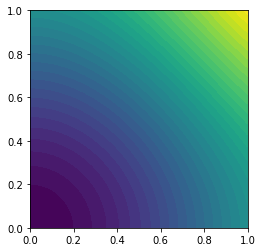

In [ ]:
from fenics import*
import matplotlib.pyplot as plt

# Monolitic Solver For Stokes - Good For 2D problems up to 1e5 degrees of freedom

def solve_Stokes(n, degree, u_exact, p_exact, f):
  #1 Mesh Gen
  nx, ny=n, n
  mesh=UnitSquareMesh(nx, ny, 'crossed')

  #2 Finite Element Space
  V = VectorElement('CG', mesh.ufl_cell(), degree+1)
  Q = FiniteElement('CG', mesh.ufl_cell(), degree)

  X = FunctionSpace(mesh, MixedElement([V, Q]))
  
  #3. Problem Definiton
  u, p=TestFunctions(X)
  v, q=TrialFunctions(X)

  def boundary(x, on_boundary):
    return on_boundary
  
  def origin(x, on_boundary):
    return near(x[0], 0.0) and near(x[1], 0.0)
  
  bc=DirichletBC(X.sub(0), u_exact, boundary)
  bc_pressure=DirichletBC(X.sub(1), p_exact(0,0), origin, 'pointwise')
  
  a=(inner(grad(u), grad(v)) - p *div(v) - div(u) * q) * dx
  L=dot(f, v) * dx
  
  #4. Solution
  x=Function(X)
  solve(a==L, x, [bc, bc_pressure])
  
  u, p=x.split()
  
  u.rename('velocity', 'velocity')
  p.rename('pressure', 'pressure')
  
  return u, p

#CONVERGENCE ANALYSIS
degree = 1

u_exact = Expression((
        '-cos(x[0]) * sin(x[1])',
        'sin(x[0]) * cos(x[1])'
    ), degree=2*degree+1)
p_exact = Expression(
    '-0.25 * (cos(2*x[0]) + cos(2*x[1]))',
    degree=2*degree+1)
f = Expression((
        '-2 * cos(x[0]) * sin(x[1]) + 0.5 * sin(2 * x[0])',
        '2 * sin(x[0]) * cos(x[1]) + 0.5 * sin(2 * x[1])'
    ), degree=2*degree+1)

for n in [5, 10, 20, 40]:
  uh, ph=solve_Stokes(n, degree, u_exact, p_exact, f)
    
  eL2=errornorm(p_exact, ph, 'L2')
  eH1=errornorm(u_exact, uh, 'H1')
    
  print('n={} degree={} eL2={} eH1={}'.format(n, degree, eL2, eH1))
  
  plot(uh) #ne konvergira metoda za tlak - rješenje ovisi o velicini mreze

  